**PROJET 6 : Détectez des faux billets**

CONTEXTE: Société de consulting informatique propose une nouvelle mission au ministère de l'Intérieur, dans le cadre de la lutte contre la criminalité organisée, à l'Office central pour la répression du faux monnayage 

**Objectif:créer un algorithme de détection de faux billets.**

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
import os

In [4]:
os.listdir()

['.config', 'sample_data']

In [5]:
os.listdir('/gdrive/MyDrive')

['CV_van15.gdoc',
 'Lettre de recommandation Lincence pro carto.gdoc',
 'Document sans titre (5).gdoc',
 'Notes de cours.gdoc',
 'passeport lindsay (1).pdf',
 'passeport lindsay.pdf',
 'reçu de Mme Zebaze.pdf',
 'CEGO20200123091813_MAIL_ComRodH01337763730 (1).rtf.gdoc',
 'CEGO20200123091813_MAIL_ComRodH01337763730.rtf.gdoc',
 'bnp-rib.pdf',
 'fiches produit.docx',
 'fiches produit.gdoc',
 'IMG-20200625-WA0010.jpg',
 'IMG-20200620-WA0052.jpg',
 'IMG-20200620-WA0051.jpg',
 'IMG-20200620-WA0048.jpg',
 'IMG-20200625-WA0019 (1).jpg',
 'IMG-20200625-WA0015 (1).jpg',
 'IMG-20200625-WA0016 (1).jpg',
 'IMG-20200625-WA0017 (1).jpg',
 '#FA001525 (1).pdf',
 'Screenshots of my payment processor page (1).PNG',
 'tarifs.pdf',
 'gross_sales_2020-03-31_2020-06-28.csv',
 'sales_2020-03-31_2020-06-28.csv',
 '#FA001525.pdf',
 'numérisation-6(1)-1(1) (1).pdf',
 'dossier-special-pousse (1).pdf',
 'numérisation-6(1) (1).pdf',
 'Support-de-notes-masterclass-01-2020-min (1).pdf',
 '15460723881440495544_thum

In [6]:
## import des librairies

In [7]:
import pandas as pd


In [8]:
import seaborn as sns
import matplotlib.patches as mpatches
import scipy.stats as st
from sklearn import preprocessing
from sklearn import decomposition
from sklearn import cluster
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [9]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [10]:
#Paramètres de style
plt.style.use('ggplot') 
plt.rcParams.update({'font.size': 12, 'axes.labelsize': 16, 'axes.titlesize': 24})

In [11]:
#Principales versions utilisées
print("Jupyter Notebook : " + str(pd.__version__))
print("Pandas : " + str(pd.__version__))
print("Numpy : " + str(np.__version__))
print("Matplotlib : " + str(matplotlib.__version__))
print("Seaborn : " + str(sns.__version__))

Jupyter Notebook : 1.1.5
Pandas : 1.1.5
Numpy : 1.19.5
Matplotlib : 3.2.2
Seaborn : 0.11.2


### Description du jeu de données 
La PJ a transmis un fichier csv contenant les caractéristiques enoncées ci-dessus.



In [12]:
#Chargement du jeu de données et aperçu des 5 premières lignes
data = pd.read_csv('/gdrive/MyDrive/notes.csv')
data.head()

is_genuine  diagonal  height_left  ...  margin_low  margin_up  length
0        True    171.81       104.86  ...        4.52       2.89  112.83
1        True    171.67       103.74  ...        4.01       2.87  113.29
2        True    171.83       103.76  ...        4.40       2.88  113.84
3        True    171.80       103.78  ...        3.73       3.12  113.63
4        True    172.05       103.70  ...        5.04       2.27  113.55

[5 rows x 7 columns]

Hors mis la variable booléenne 'is_genuine', les 6 autres variables sont quantitatives continues.

In [13]:
#Identification des effectifs par type de billet vrai/faux(méthode utilisée .value_counts())
effectif = data['is_genuine'].value_counts()
modalite = effectif.index #l'index de 'effectifs' contient les modalités

tab = pd.DataFrame(modalite, columns = ['is_genuine']) #création du tableau à partir des modalités
tab["n"] = effectif.values
tab["f"] = tab["n"] / len(data) #len(data) renvoie la taille de l'échantillon
tab

is_genuine    n         f
0       True  100  0.588235
1      False   70  0.411765

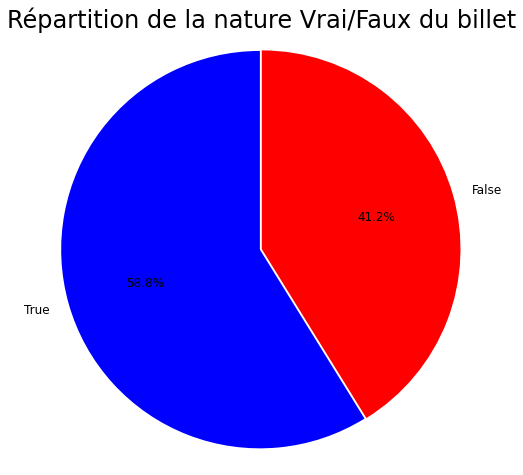

In [14]:
#Création d'un Pie Chart pour représenter la part de chaque type de billet
labels = 'True', 'False'
sizes = tab['f']
explode = (0.01, 0)

fig1, ax = plt.subplots(figsize=(8,8))
ax.pie(sizes, explode=explode, labels=labels, colors=['blue','red'], 
        autopct='%1.1f%%', shadow=False, startangle=90)

ax.axis('equal') 
plt.title('Répartition de la nature Vrai/Faux du billet')

plt.savefig("piechart.png")
plt.show()

Identifions la taille de notre jeu de données

In [15]:
#Taille du jeu de données
data.shape

(170, 7)

Le jeu de données contient 170 observations, 7 variables dont 1de type booléenne nommée "is_genuine"permettant d'authentifier le billet (vrai ou faux billet de banque).

In [16]:
# Visualisaton des valeurs descriptives des variables quantitatives afin d'avoir une première idée des données que nous avons 
data.describe().T

count        mean       std  ...      50%       75%     max
diagonal      170.0  171.940588  0.305768  ...  171.945  172.1375  173.01
height_left   170.0  104.066353  0.298185  ...  104.055  104.2875  104.86
height_right  170.0  103.928118  0.330980  ...  103.950  104.1700  104.95
margin_low    170.0    4.612118  0.702103  ...    4.450    5.1275    6.28
margin_up     170.0    3.170412  0.236361  ...    3.170    3.3300    3.68
length        170.0  112.570412  0.924448  ...  112.845  113.2875  113.98

[6 rows x 8 columns]

Analyse des données: recherche des valeurs manquantes, doublons,valeurs negatives

In [17]:
#Recherche de valeur(s) manquante(s)
data.isna().any()

is_genuine      False
diagonal        False
height_left     False
height_right    False
margin_low      False
margin_up       False
length          False
dtype: bool

Le jeu de données ne présente aucune valeur manquante, la fonction .isna().any() ne renvoie aucun "True".

In [18]:
#Recherche de doublons 
data.duplicated().sum()

0

Le jeu de données n'a pas de doublon, la fonction .duplicated().sum() ne renvoie aucune valeur en double

In [19]:
#Recherche de valeur(s) négative(s) 
display(data[data<0].count())

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

Aucune valeur négative identifée dans le jeu de donnée

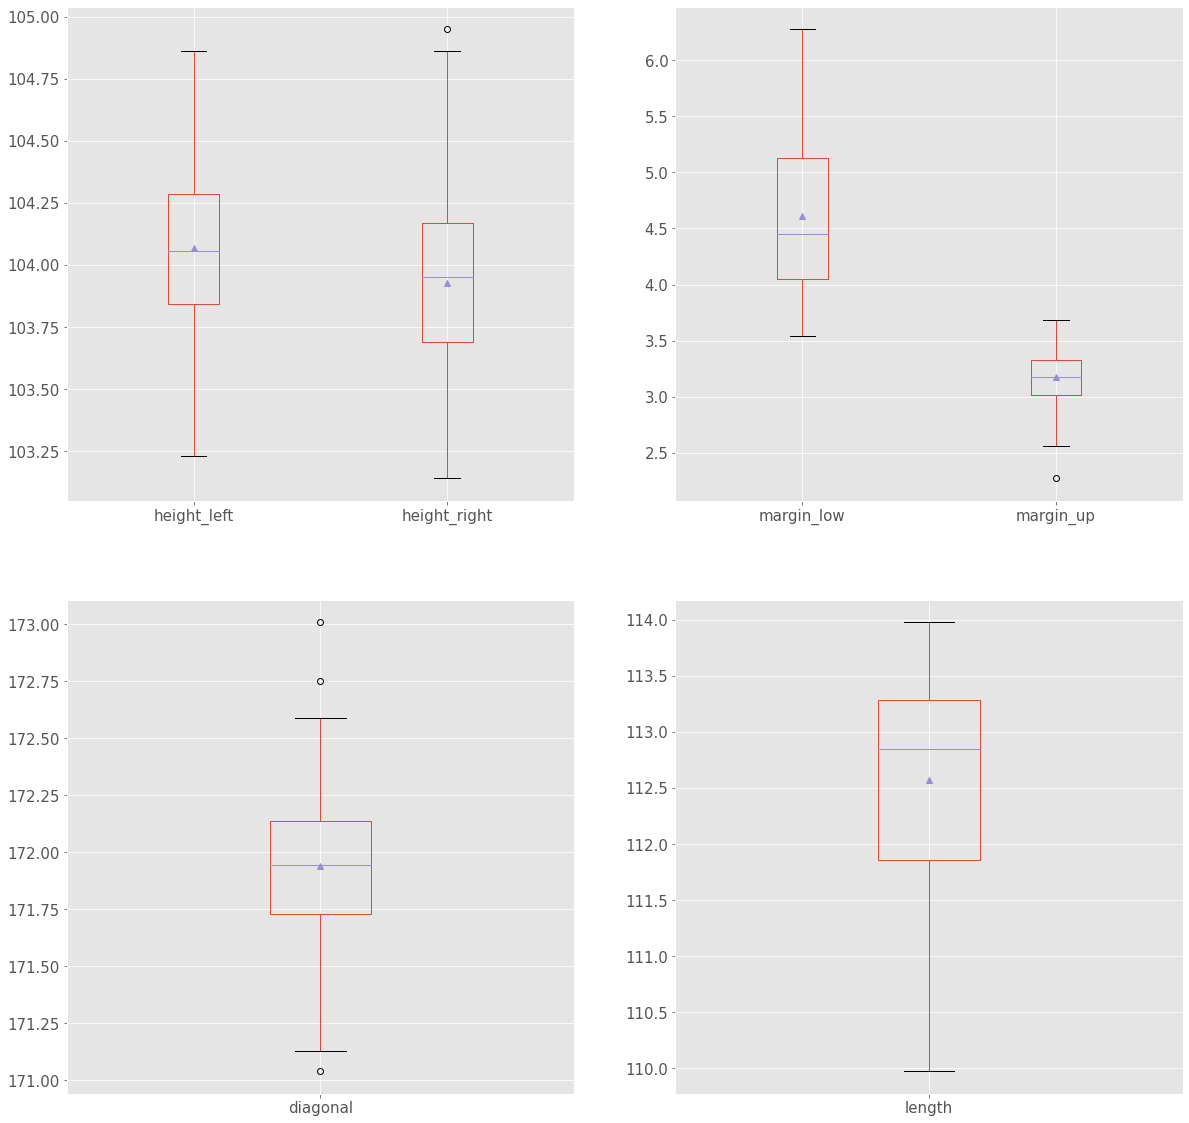

In [20]:
# identification visuelle par Boxplot de la distribution des variables et des éventuels outliers sans prendre en compte la nature du billet c'est-à-dire sans la variable "is geniune"
plt.figure(figsize=(20, 20))
plt.title('Boxplot billet sans distinction vrai/faux')

plt.subplot(221)
data.iloc[:, 2:4].boxplot(fontsize=15, widths=0.2, showmeans=True)
plt.subplot(222)
data.iloc[:, 4:6].boxplot(fontsize=15, widths=0.2, showmeans=True)
plt.subplot(223)
data.iloc[:, 1:2].boxplot(fontsize=15, widths=0.2, showmeans=True)
plt.subplot(224)
data.iloc[:, -1:].boxplot(fontsize=15, widths=0.2, showmeans=True)

plt.savefig("boxplot_1.png")
plt.show()

A partir des Boxplots ci-dessus on peut identifier quelques outliers

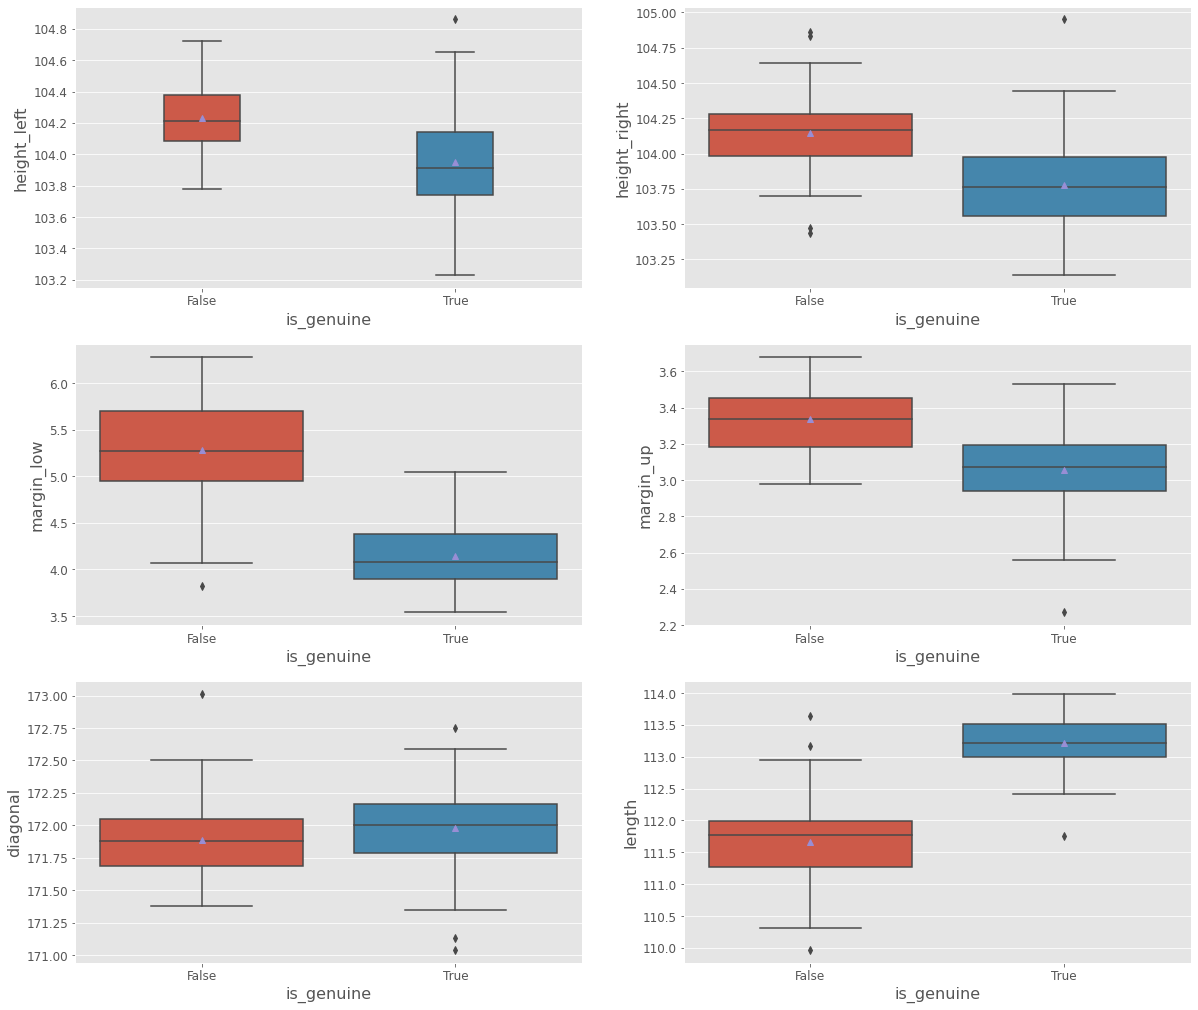

In [21]:
# identification des outliters en prenant en compte la nature du billet (vrai/ faux) donc en tenant compte de la variable "is geniune"
plt.figure(figsize=(20, 30))

plt.subplot(521)
sns.boxplot(x='is_genuine', y='height_left', width=0.3, data=data, showmeans=True)
plt.subplot(522)
sns.boxplot(x='is_genuine', y='height_right', data=data, showmeans=True)
plt.subplot(523)
sns.boxplot(x='is_genuine', y='margin_low', data=data, showmeans=True)
plt.subplot(524)
sns.boxplot(x='is_genuine', y='margin_up', data=data, showmeans=True)
plt.subplot(525)
sns.boxplot(x='is_genuine', y='diagonal', data=data, showmeans=True)
plt.subplot(526)
sns.boxplot(x='is_genuine', y='length', data=data, showmeans=True)

plt.savefig("boxplot_2.png")
plt.show()

**Observations** :

les métriques 'margin' et 'height' ont des moyennes et médianes plus élevées pour les faux billets.

la métrique 'length' a une moyenne et médiane plus basse pour les faux billets.
la métrique 'diagonal' ne semble pas être significative
.
Des outliers sont visibles, mais restent relativement proches des queues de distribution. Ces outliers seront conservés pour la suite de l'analyse.

Analyse bivariée de notre jeu de données

In [22]:
#Matrice des corrélations linéaires par l'utilisation de la méthode .corr()
data.iloc[:, 1:].corr()

diagonal  height_left  ...  margin_up    length
diagonal      1.000000     0.319584  ...  -0.027366  0.080295
height_left   0.319584     1.000000  ...   0.324788 -0.421387
height_right  0.220418     0.734390  ...   0.366918 -0.417021
margin_low   -0.181020     0.424530  ...   0.171113 -0.637352
margin_up    -0.027366     0.324788  ...   1.000000 -0.525284
length        0.080295    -0.421387  ...  -0.525284  1.000000

[6 rows x 6 columns]

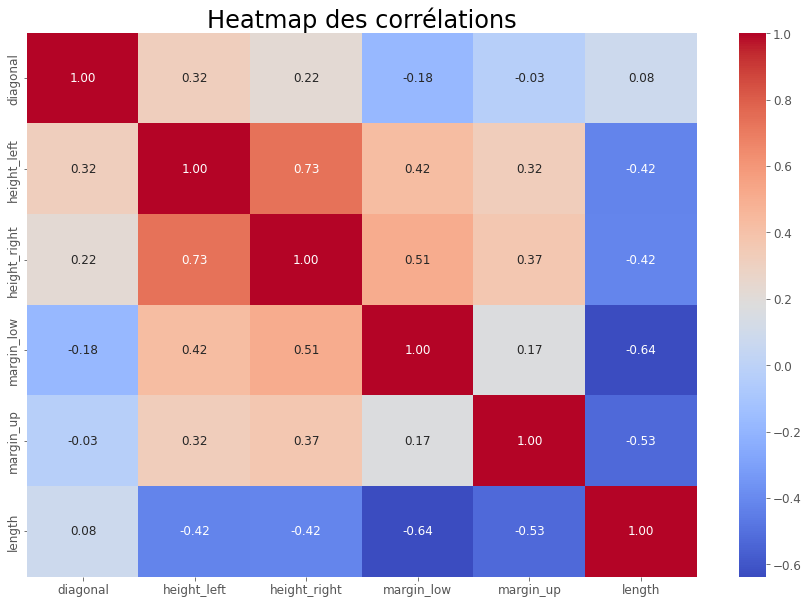

In [23]:
#HeatMap des corrélations linéaires à partir de la matrice précédente
plt.figure(figsize=(15, 10))
sns.heatmap(data.iloc[:, 1:].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Heatmap des corrélations')

plt.savefig("heatmap.png")
plt.show()

Il existe des corrélations linéaires existent entre certaines de nos variables. 

Une analyse dans le détail pour les apprécier est nécessaire 


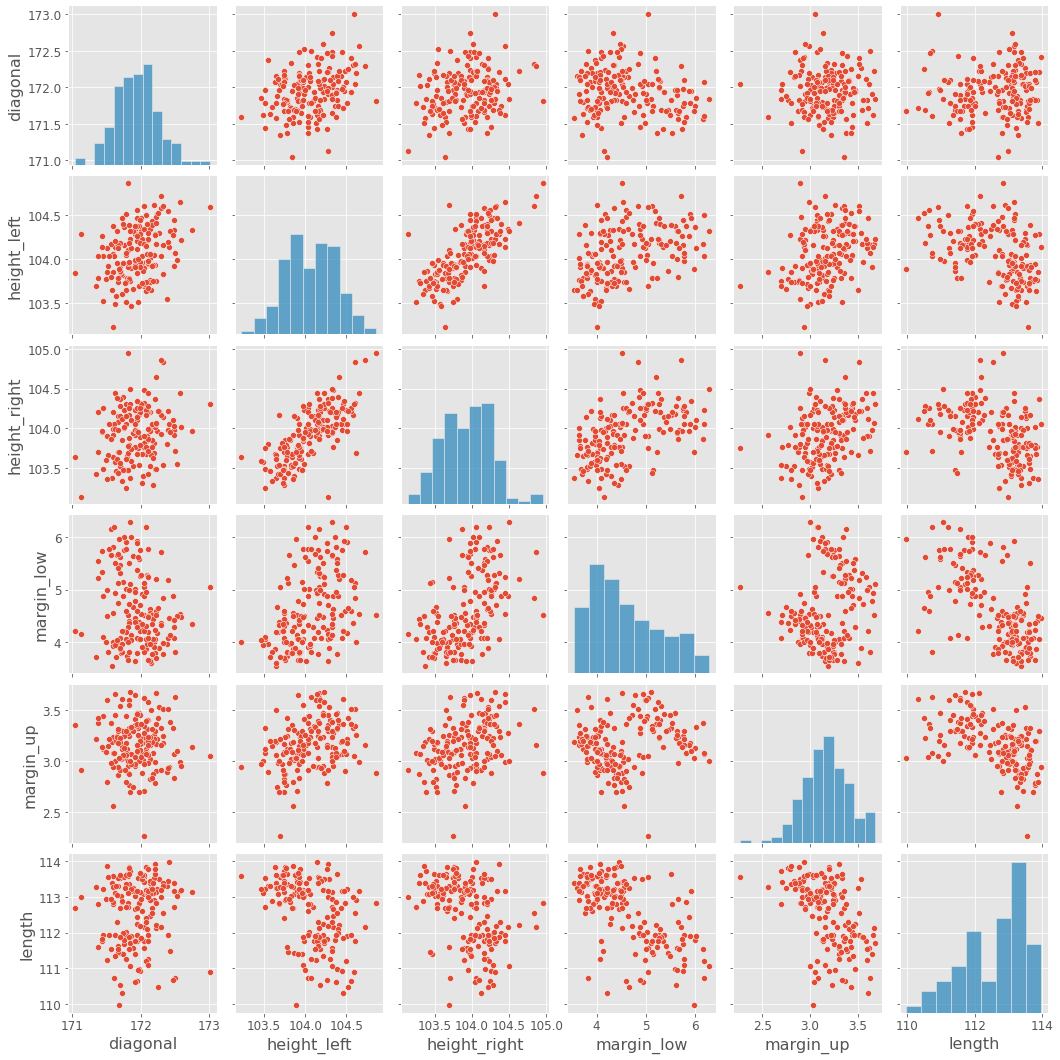

In [24]:
#Visualisation des 6 variables quantitatives
#.pairplot une méthode de Seaborn simple et rapide pour se faire une idée visuelle des corrélations ou non
sns.pairplot(data.iloc[:, 1:])

plt.savefig("pairplot.png")
plt.show()

On observe une corrélation linéaire entre les deux variables 'height_left' et 'height_right',confirmons celà au travers du calcul du  coefficient de pearson

In [25]:
#Coefficient de corrélation linéaire de Pearson entre 'height_left' et 'height_right'
coef_height = st.pearsonr(data['height_right'], data['height_left'])[0]
coef_height

0.7343902682297875

La valeur obtenue est proche de 1, il existe donc une réelle corrélation linéaire entre ces deux variables.

In [26]:
#Coefficient de corrélation linéaire de Pearson entre 'length' et 'margin_low'
coef_length_margin = st.pearsonr(data['length'], data['margin_low'])[0]
coef_length_margin

-0.6373516884716645

La valeur obtenue est proche de -1, il existe donc une corrélation linéaire négative entre ces deux variables.

Les prochaines étapes de l'analyse porteront sur la "sélection des variables à inclure dans le modèle de régression logistique

Lors de cette démarche, il ne faut pas inclure des variables redondantes (trop liées entre elles). Dans un tel cas, on parle de colinéarité entre ces variables. Ce problème a pour conséquence un modèle de qualité médiocre

**Analyse en composantes principales de l'échantillon**, en suivant les étapes ci-dessous
- Analyse de l'éboulis des valeurs propres,
- Représentation des variables par le cercle des corrélations,
- Représentation des individus par les plans factoriels,
- Analyse de la qualité de représentation et la contribution des individus.

Pour chacune de ces étapes, il est nécessaire d'apporter une interprétation des résultats obtenus.

La variable "is geniuine" précisant la nature Vrai/Faux du billet sera utilisée comme variable illustrative.

In [27]:
#Préparation du jeu de données pour l'ACP
df = data.copy()
df.index = df['is_genuine']
del df['is_genuine']

In [28]:
#Transformation des données en array Numpy
X = df.values

In [29]:
#Centrage/réduction des données (éviter les écarts d'échelle, les données prendront toutes la même importance)
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

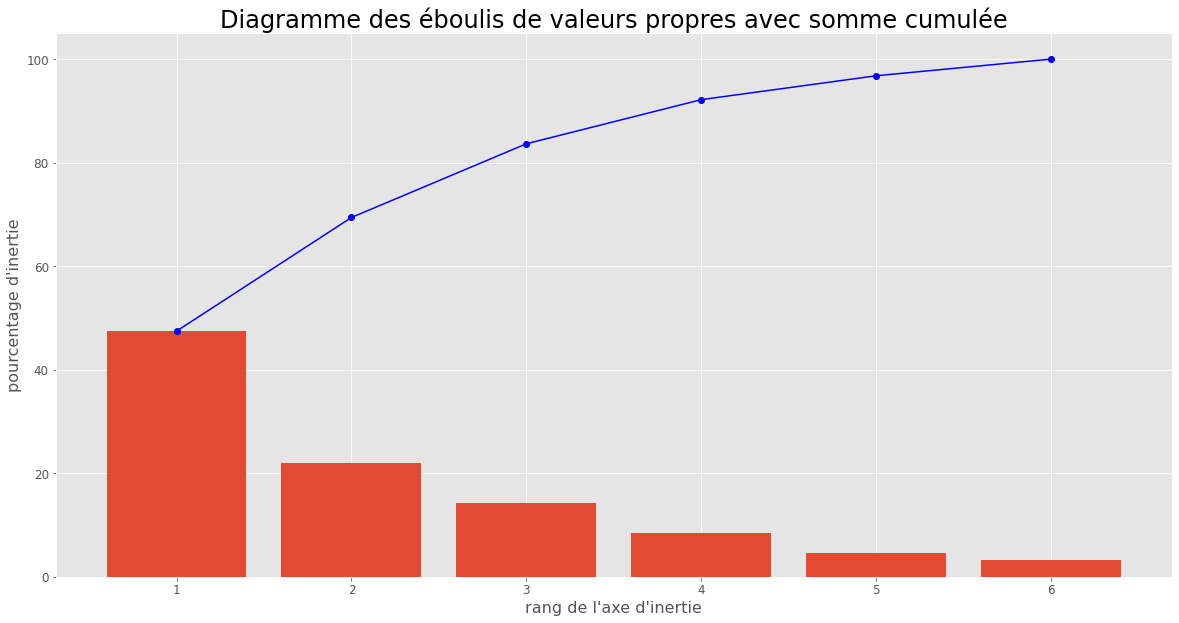

In [30]:
#Représentation de la variance expliquée: Diagramme des éboulis de valeurs propres avec somme cumulée
pca = decomposition.PCA()
pca.fit(X_scaled)
scree = pca.explained_variance_ratio_*100

plt.figure(figsize(20,10))
plt.bar(np.arange(len(scree))+1, scree)
plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="blue",marker='o')
    
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Diagramme des éboulis de valeurs propres avec somme cumulée")

plt.savefig("eboulis_valeurs_propres.png")
plt.show()

**Les barres orange montrent le pourcentage de variance expliqué par chaque composante principale** (cela vient du calcul du pourcentage de la variance expliquée). 

**La ligne bleue montre la somme cumulée** (elle vient de pca.explained_variance_ratio_.cumsum()).

À partir du scree plot (diagramme des éboulis des valeurs propres), nous pouvons lire le pourcentage de la variance dans les données expliquées lorsque nous ajoutons les composants principales.

**Ainsi, la première composante principale explique 47 % de la variance de l'ensemble de données. 69% de la variance est expliquée par les 2 premières composantes**

In [31]:
#Calcul des composantes principales sur les deux premières
pca = decomposition.PCA(n_components=2)
pca.fit(X_scaled)

PCA(n_components=2)

In [32]:
#Pourcentage de variance expliquée par les composantes principales à l'aide de .explained_variance_ratio_
print(pca.explained_variance_ratio_.cumsum())

[0.47447921 0.69405027]


69% de la variance des données est expliquée par les deux premières composantes. L'analyse sera traitée ainsi, car l'ajout d'autres composantes n'apporte pas réellement de valeur ajoutée


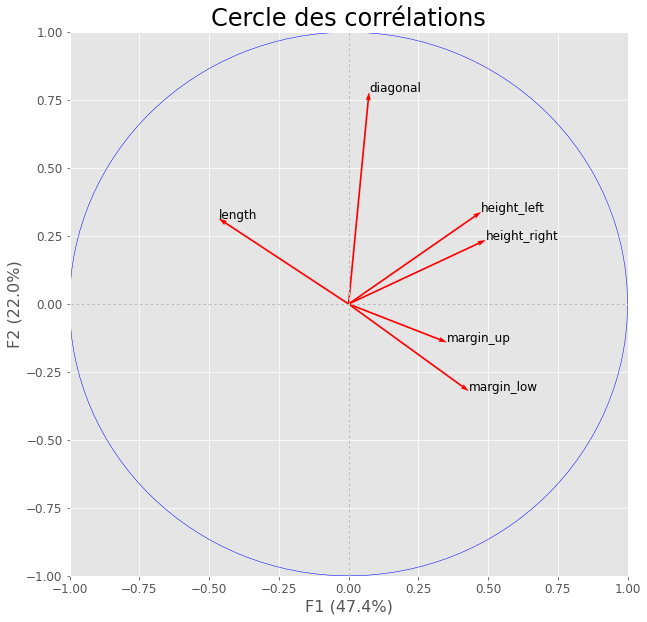

In [33]:
#Cercle des corrélations des variables
pcs = pca.components_

fig = plt.subplots(figsize=(10,10))
plt.xlim(-1,1)
plt.ylim(-1,1)

plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
           pcs[0,:], pcs[1,:], angles='xy', scale_units='xy', scale=1, color='r', width= 0.003)

for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    plt.text(x, y, df.columns[i])
    
circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
plt.gca().add_artist(circle)

# Ajout des axes
plt.plot([-1,1],[0,0],color='silver',linestyle='--',linewidth=1)
plt.plot([0,0],[-1,1],color='silver',linestyle='--',linewidth=1)

plt.title('Cercle des corrélations')
plt.xlabel('F{} ({}%)'.format(1, round(100*pca.explained_variance_ratio_[0],1)))
plt.ylabel('F{} ({}%)'.format(2, round(100*pca.explained_variance_ratio_[1],1)))

plt.savefig("cercle_correlation.png")
plt.show()

Avec le cercle de correlation**: etudier les liaisons entre les variables **. 

On va chercher à savoir si dans nos variables il y'a des groupes de variables qui sont fortement correlés entre elles ( deux à deux). 

Si de tels grpes existent alors ttes les variables d'un groupe donné seront synthétisables " resumables" par une variable synthétique. Ces variables synthétiques **sont en fait les composantes principales F1, F2 F3 etc. **


A partir de cette représentation graphique, nous pouvons déterminer les variables qui se révélent être les plus corrélées aux composantes F1 et F2. Notons également que la longueur des flèches est importante, une variable dont la longueur de la flèche est proche de 1 sera extrêmement bien représentée...


Ce cercle de rayon 1 de correlation a été réalisé a partir des scores des composantes retenues c a dire les composantes 1 et 2. Leurs scores etaient indiquées sur le diagramme des eboulis de 47% et de 22% respectivement.


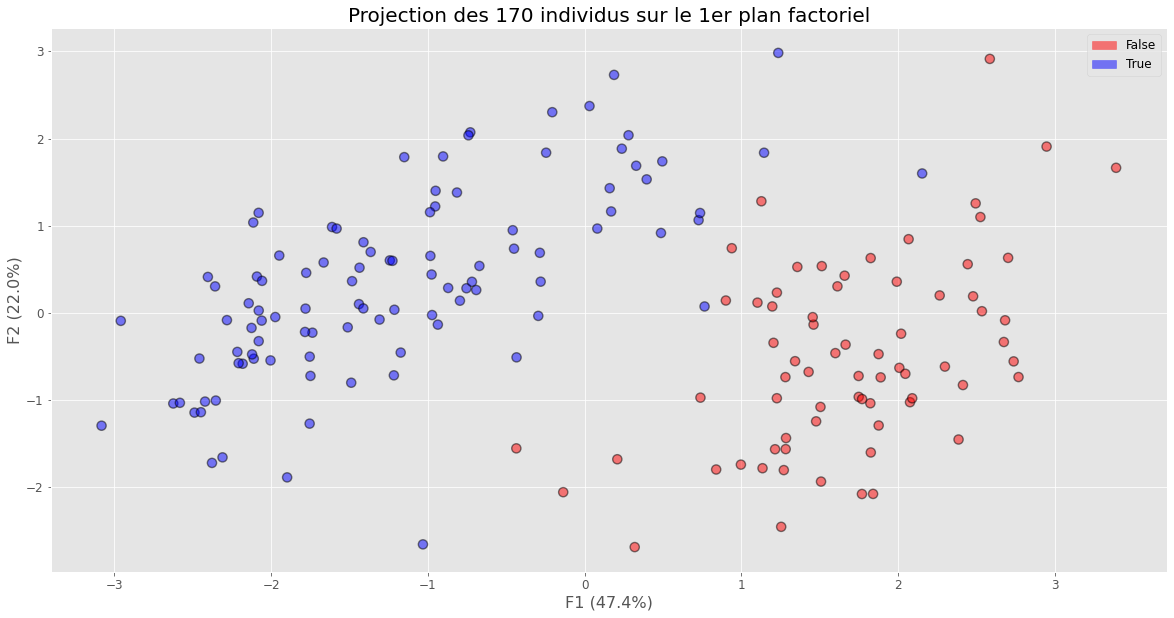

In [34]:
#Coordonnées factorielles 
X_projected = pca.transform(X_scaled)
plt.figure(figsize=(20, 10))

#Projection des indivifus par scatter Plot sur le premier plan factoriel
colors = ['red', 'blue']
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=data['is_genuine'].apply(lambda x: colors[x]), 
            alpha=0.5, edgecolors='black', linewidths=1.4, s=85)

#Labels de la nature des billets
lab_0 = mpatches.Patch(color='red', alpha=0.5, label='False')
lab_1 = mpatches.Patch(color='blue', alpha=0.5, label='True')
plt.legend(handles=[lab_0, lab_1])

plt.xlabel('F{} ({}%)'.format(1, round(100*pca.explained_variance_ratio_[0],1)), fontsize=16)
plt.ylabel('F{} ({}%)'.format(2, round(100*pca.explained_variance_ratio_[1],1)), fontsize=16)
plt.title("Projection des {} individus sur le 1er plan factoriel".format(X_projected.shape[0]), fontsize=20)

plt.savefig("projection_pca.png")
plt.show()

In [35]:
#Coefficients de la composante principale F1
F1 = pca.components_[0]
print(F1) 
#Coefficients de la composante principale F2
F2 = pca.components_[1]
print(F2)

[ 0.07327499  0.47550205  0.4918214   0.43102671  0.35253984 -0.46537288]
[ 0.77963908  0.33925019  0.23554253 -0.32053699 -0.14111974  0.31453645]



**Chaque score de  F1 ET F2 a une valeur ou « score » pour chaque variable**. Le score montre à quel point la variable influence la composante principale. Rappelons-nous quelles colonnes nous avons dans les données :

Ainsi, dans ce qui précède, la première variable est la diagonale . Pour la  diagonale en F1, le scores de 0,07 et en F2 0,77. Il est clair que la diagonale a plus d'influence sur PC2 que sur PC1.

Le premier plan factoriel est de loin le plus représentatif pour pouvoir effectuer une projection des variables et des individus notamment de part le resultat du % de leur inertie. 

Interprétation des projections réalisées :
F1 : représente la longueur du billet / hauteur ainsi que la marge

F2 : représente la longueur de la diagonale

L'axe de la première composante est celui qui sépare principalement les vrais billets des faux billets. De plus, F1 explique 47% de l'inertie. Sur la plupart des observations F1 permet l'identification des billets. Concernant les valeurs proches de zéro, c'est F2 qui permet de discriminer.

Le second axe explique 22% de l'inertie et participe à la séparation des vrais billets et des faux billets.

On voit qu'une diagonale sépare clairement les vrais et les faux billets.

In [36]:
#Calcul des composantes principales
#Ici seulement F1 et F2 seront utiles à l'interprétation attendue

df_facto = pd.DataFrame(X_projected, index=data.index, columns=["F" + str(i+1) for i in range(2)]).iloc[:, :2]
df_facto

F1        F2
0    2.153639  1.599709
1   -2.110416 -0.526039
2   -1.973152 -0.048102
3   -2.059795 -0.089105
4   -2.403180  0.412170
..        ...       ...
165  2.478626  0.189974
166  2.585331  2.914472
167  2.067245  0.845602
168  0.739257 -0.972965
169  1.504992 -1.079725

[170 rows x 2 columns]

Contribution des individus dans l'inertie totale

In [37]:
#Contribution des individus dans l'inertie totale
di = np.sum(X_scaled**2,axis=1)
ctr_indiv_inertie = pd.DataFrame({'c_inertie':di, 'is_genuine':df.index})
ctr_indiv_inertie

c_inertie is_genuine
0    18.410598       True
1     5.444799       True
2     4.960527       True
3     4.805719       True
4    18.039567       True
..         ...        ...
165   7.673233      False
166  20.625650      False
167   8.567410      False
168   3.482926      False
169   5.369633      False

[170 rows x 2 columns]

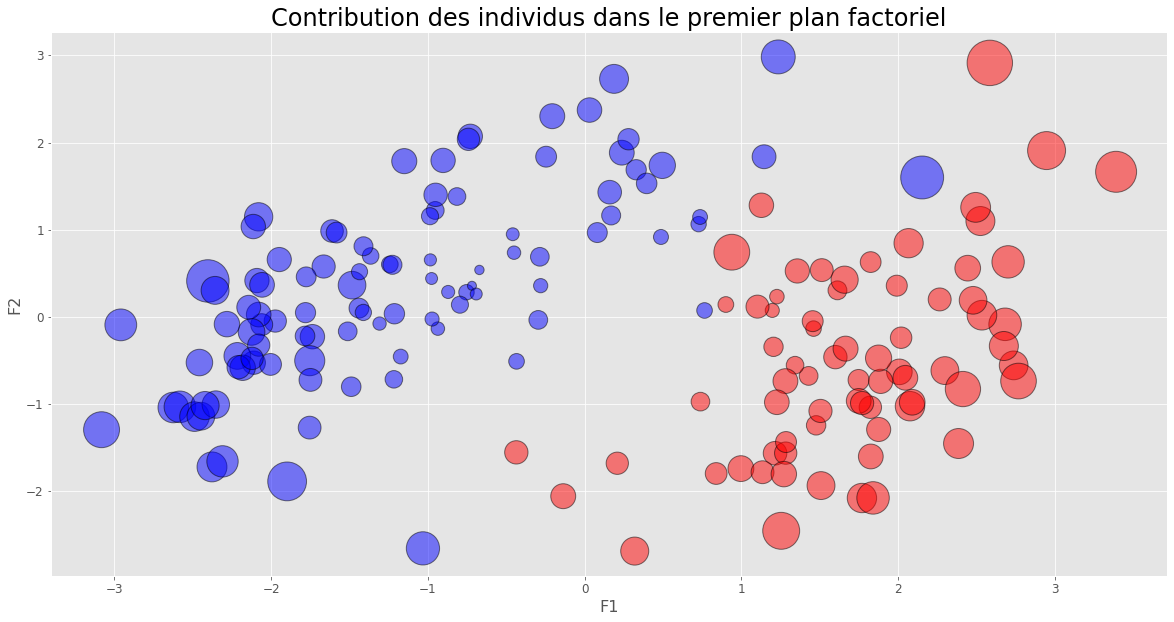

In [38]:
#Scatter Plot de la contribution des individus dans l'inertie totale
color = ['red', 'blue']
plt.scatter(df_facto['F1'], df_facto['F2'], c=data['is_genuine'].apply(lambda x: colors[x]), 
            alpha=0.5, edgecolors='black', linewidths=1,
            s=ctr_indiv_inertie['c_inertie']*100)

plt.xlabel('F1')
plt.ylabel('F2')
plt.title('Contribution des individus dans le premier plan factoriel')

plt.savefig('contribution_inertie.png')
plt.show()

Il est judicieux de remarquer, du moins de prêter attention aux points dont la contribution est supérieure à la moyenne, car se sont ces individus qui permettent de donner un sens à l’axe.

**Qualité de réprésentation des individus (COS2)**

In [39]:
#Qualité de représentation des individus - COS2
cos2 = X_projected**2
n_comp = 2

for j in range(n_comp):
    cos2[:,j] = cos2[:,j]/di
    
cos2_indiv = pd.DataFrame({'COS2_1':cos2[:,0],'COS2_2':cos2[:,1], 'is_genuine': data['is_genuine']})
cos2_indiv

COS2_1    COS2_2  is_genuine
0    0.251929  0.139000        True
1    0.818002  0.050822        True
2    0.784862  0.000466        True
3    0.882856  0.001652        True
4    0.320145  0.009417        True
..        ...       ...         ...
165  0.800651  0.004703       False
166  0.324059  0.411824       False
167  0.498809  0.083461       False
168  0.156908  0.271800       False
169  0.421817  0.217111       False

[170 rows x 3 columns]

Lorsque l’angle est proche de 0, c'est-à-dire que le cosinus est proche de 1, l’individu est bien représenté. Dans le cas inverse, l’angle est proche de 90° et le cosinusest proche de 0.

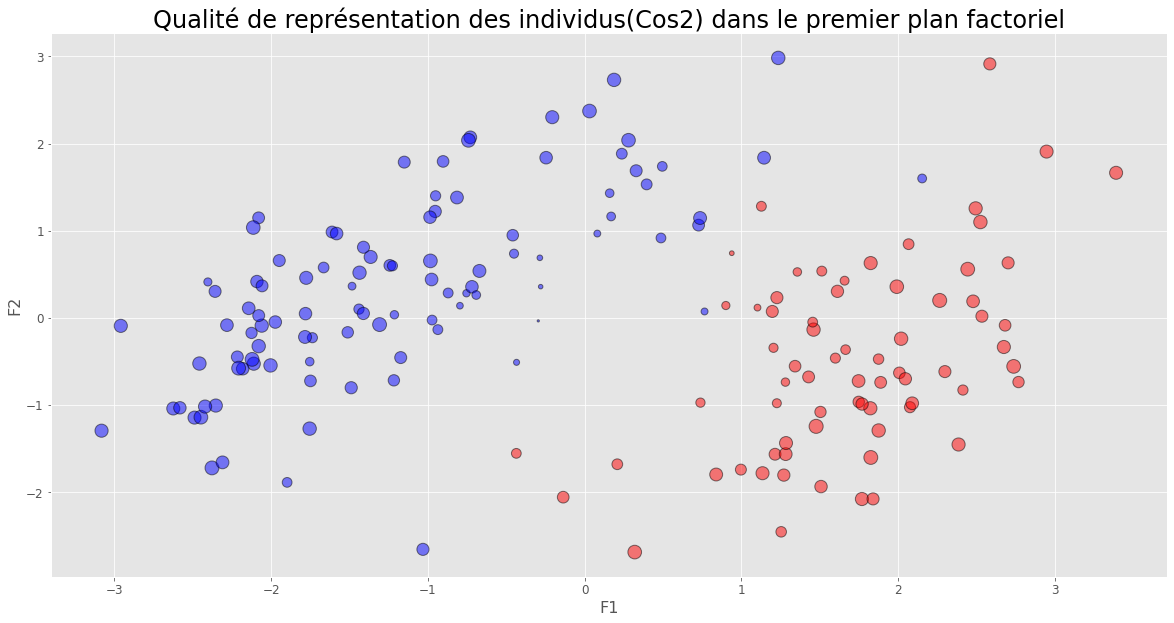

In [40]:
#Scatter Plot de la qualité de représentation des individus dans le 1er plan factoriel
cos2_indiv['COS2_1 + COS2_2'] = cos2_indiv['COS2_1'] + cos2_indiv['COS2_2']
colors = ['red', 'blue']
plt.scatter(df_facto['F1'], df_facto['F2'], c=data['is_genuine'].apply(lambda x: colors[x]), 
            alpha=0.5, edgecolors='black', linewidths=1,
            s=cos2_indiv['COS2_1 + COS2_2']*200)

plt.xlabel('F1')
plt.ylabel('F2')
plt.title('Qualité de représentation des individus(Cos2) dans le premier plan factoriel')

plt.savefig('qualite_representationcos2.png')
plt.show()

Ce scatter plot sur le premier plan factoriel nous démontre que les individus sont relativement très bien représentés. En effet, un individu mal représenté sera proche de l'origine, avec par conséquent peu de contribution à la formation des axes étudiés. Ici, ce n'est pas le cas, on distingue parfaitement deux groupes d'individus, avec un large espace proche de l'origine.

**Classification par l'algorithme K-Means ( méthode des centres mobiles)**

Utilisation du package «scikit-learn» 

Une fois le clustering réalisé, les clusters seront visualisés dans le premier plan factoriel de l'ACP.

Choix du nombre du cluster


Le contexte métier nous oriente naturellement vers un k=2, traçons l'inertie pour vérifier que le k=2 est bien la solution optimale.

Détection du nombre de classes – Graphique de l’inertie intra-classes W


Principe :Une stratégie simple pour identifier le nombre de classes consiste à faire varier
K et surveiller l’évolution de l’inertie intra-classes W. L’idée est de visualiser le « coude »
où l’adjonction d’une classe ne correspond à rien dans la structuration des données.

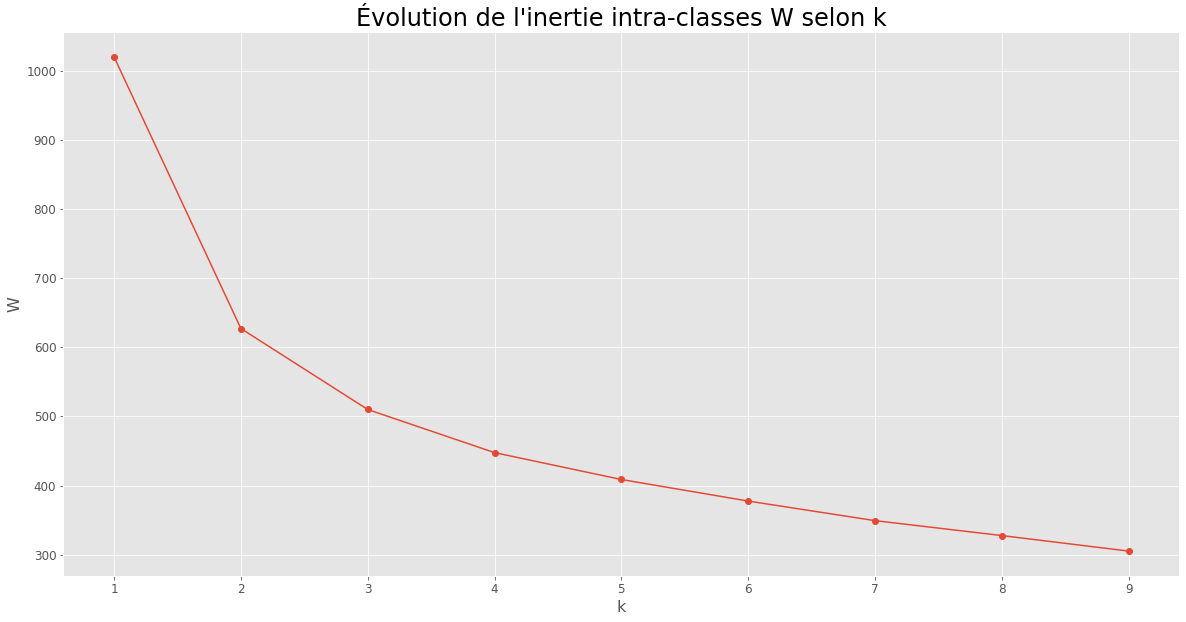

In [42]:
#Liste dans laquelle on stocke les inerties
inerties=[]

#Boucle de 1 à 9 pour tester toutes ces possibiliéts
for k in range(1, 10):
    #pour chaque k, on crée un modèle et on l’ajuste
    km = cluster.KMeans(n_clusters=k)
    km.fit(X_scaled)
    #on stocke l’inertie associée
    inerties.append(km.inertia_)

#Visualisation des valeurs d'inertie pour chaque nombre de cluster
plt.plot(range(1, 10), inerties, marker='o')
plt.xlabel('k')
plt.ylabel('W')
plt.title("Évolution de l'inertie intra-classes W selon k")

plt.savefig("kmeans_inertie.png")
plt.show()

Par la Méthode du coude, la confirmation d'un k=2 prend tout son sens. En effet, l'ajout d'un ou plusieurs groupes n'apporterait pas d'information pertinente dans le contexte.

In [43]:
#Classification des individus par apprentissage non-supervisé K-Means en deux clusters 
cls = cluster.KMeans(n_clusters=2) 
cls.fit(X_scaled)

KMeans(n_clusters=2)

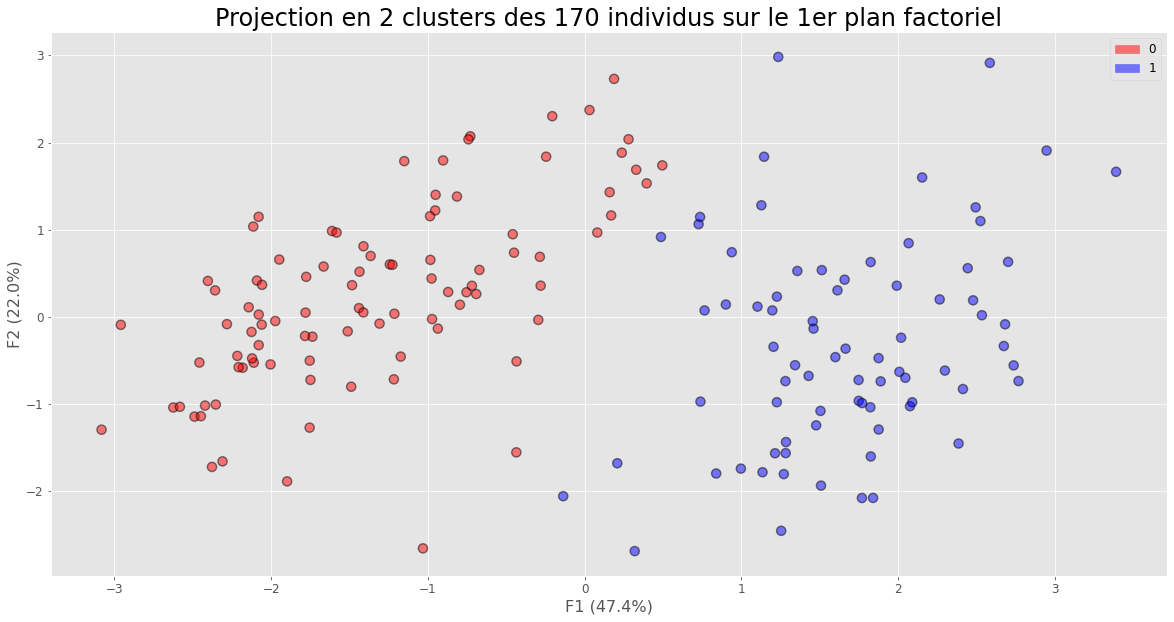

In [44]:
#Visualisation de nos deux clusters dans le premier plan factoriel

plt.figure(figsize=(20, 10))

categories = cls.labels_
colormap = np.array(['red', 'blue'])

plt.scatter(X_projected[:, 0], X_projected[:, 1], c=colormap[categories], 
            alpha=0.5, edgecolors='black', linewidths=1.4, s=85)

lab_0 = mpatches.Patch(color='red', alpha=0.5, label='0')
lab_1 = mpatches.Patch(color='blue', alpha=0.5, label='1')
plt.legend(handles=[lab_0, lab_1])

plt.xlabel('F{} ({}%)'.format(1, round(100*pca.explained_variance_ratio_[0],1)))
plt.ylabel('F{} ({}%)'.format(2, round(100*pca.explained_variance_ratio_[1],1)))
plt.title("Projection en 2 clusters des {} individus sur le 1er plan factoriel".format(X_projected.shape[0]))

plt.savefig("projection_kmeans.png")
plt.show()

Plus de 69% de la variance des données est expliquée par les deux premières composantes, ce qui est plutôt pas mal. L'avantage du K-Means est d'obtenir directement des données centrées/réduites facilitant l'interprétation. **calculons ci-dessous les centroïdes des deux clusters pour chacune des 6 variables.**

In [45]:
#Tableau des Centroïdes 2 clusters dans sa version centrée réduite
#La comparaison est tout de suite simplifiée, les dimensions prenant la même importance!
centroids = cls.cluster_centers_
pd.DataFrame(centroids, columns=df.columns)

diagonal  height_left  height_right  margin_low  margin_up    length
0  0.064022    -0.521604     -0.581005   -0.679283  -0.510041  0.729798
1 -0.079185     0.645141      0.718611    0.840166   0.630841 -0.902645

In [46]:
#Intégration des clusters dans notre dataframe "df_cls" par la méthode .concat()
df_cls = pd.DataFrame(cls.fit_predict(X), columns=['cluster'])
df_cls = pd.concat([df_cls, data], axis=1)
df_cls.head()

cluster  is_genuine  diagonal  ...  margin_low  margin_up  length
0        1        True    171.81  ...        4.52       2.89  112.83
1        1        True    171.67  ...        4.01       2.87  113.29
2        1        True    171.83  ...        4.40       2.88  113.84
3        1        True    171.80  ...        3.73       3.12  113.63
4        1        True    172.05  ...        5.04       2.27  113.55

[5 rows x 8 columns]

In [47]:
#Tableau des correspondances clusters/nature billets
tableau = pd.crosstab(cls.labels_,df_cls['is_genuine'])
tableau.index = ['Cluster 0 - Faux','Cluster 1 - True']
tableau.columns = ['Faux','Vrais']
tableau

Faux  Vrais
Cluster 0 - Faux    68      1
Cluster 1 - True     2     99

Le clustering apporte une classification des billets en fonction des caractéristiques quantitatives. Il est aussi intéressant de pouvoir utiliser les centroïdes pour se faire une idée complémentaire à celle déjà faite à partir des cercles des corrélations, mais aussi à partir des premiers boxplots établis en début d'analyse.



Voyons maintenant comment exploiter cette classification.  Nous allons désormais pouvoir modéliser et inférer des propriétés en utilisant une méthode de classification supervisée, la régression logistique.

**Modélisation des données à l'aide d'une Régression Logistique**


**Utilisation du package «scikit-learn»**



Dans cette dernière phase de l'analyse, il sera question d'élaborer un programme capable d'effectuer une prédiction sur un billet, c'est-à-dire de déterminer s'il s'agit d'un vrai ou d'un faux billet. Pour chaque billet, l'algorithme de classification donnera la probabilité que le billet soit vrai. Si cette probabilité est supérieure ou égale à 0.5, le billet sera considéré comme vrai. Dans le cas contraire, il sera considéré comme faux.

In [48]:
#Préparation des données
X = df_cls.copy()
X = X.iloc[:, 2:]
y = df_cls.iloc[:, 0]

In [49]:
#Séparation entre les données d'entrainement et les données test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

X_train c'est le jeu qu'on va donner à  notre modèle pour qu'il s'entraine. Il va analyser les données et essayer de trouver comment il les sépare. Le jeu de test va lui nous permettre de vérifier à partir des données que le modele ne connait pas donc qu'il n'a pas eu ,si ses predictions sont cohérentes par rapport aux vraies données constatées

Ici, l'ensemble de données est divisé en deux parties dans un rapport de 20/80. Cela signifie que 80% des données seront utilisées pour la formation des modèles et 20% pour les tests des modèles. Les données étant assez limitées, le choix des 20% pour les données de test est choisi.

In [50]:
#Instanciation d'un modèle nommé lr
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [73]:
#Sauvegarde du modèle lr 
import pickle
with open('model.pkl', 'wb') as f:
    my_pickler = pickle.Pickler(f)
    my_pickler.dump(lr)

Construction du modèle ou création du modèle . Ensuite entrainons le avec X_train et Y_train. A ce niveau nos données sont deja prêtes.

In [51]:
#Faire des predictions
y_pred =lr.predict(X_test)
lr.score(X_test,y_test)

1.0

In [52]:
classifier=LogisticRegression(random_state=0,solver='liblinear')
classifier.fit(X_train,y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [53]:
y_pred=classifier.predict(X_test)
classifier.score(X_test,y_test)

1.0

In [54]:
from sklearn.metrics import accuracy_score
print('Accuracy score:',accuracy_score(y_test,y_pred))

Accuracy score: 1.0


y_pred=resultats des prediction sur xtest. On lui demande de faire des prediction . X_test est mon jeu de test, il me fait des prediction et compare ces resultats à Y_test( à mes vraies valeurs constatees). On a un taux de fiabilité = 100% ce qui pour un algo de classifi est excellent. C'est une premiere facon de faire un scroring sur notre modele pour savoir s'il est bon ou pas. 

**Évaluation du modèle à l'aide de la matrice de confusion.**

Une matrice de confusion est un tableau utilisé pour évaluer les performances d'un modèle de classification. A l'aide de cette matrice il sera simple et rapide d'appréhender la pertinence du modèle élaboré. Le principe fondamental d'une matrice de confusion est le nombre de prédictions correctes et incorrectes qui sont résumées par classe. On va juste comparer les resuktats de nos ytest avec les Y_pred ( valeurs predits)

In [55]:
from sklearn.metrics import confusion_matrix
y_pred = lr.predict(X_test)
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix) 

[[11  0]
 [ 0 23]]


Ici, on peut voir la matrice de confusion sous la forme de l'objet tableau. La dimension de cette matrice est 2*2 car ce modèle est une classification binaire. on a en deux classes 0 et 1. Les valeurs diagonales représentent des prédictions précises, tandis que les éléments non diagonaux sont des prédictions inexactes. Dans la sortie, 11 et 23 sont des prédictions réelles, et 0 et 0 sont des prédictions incorrectes.

11= vrai postif , 23 vrai negatis
0= faux negatif, 0=faux positif= billet est faux mais le model predit qu'il est vrai
faux negatif = billet est vrai mais le model predit qu'il est faux


Les coefficients sur la diagonale indiquent les éléments bien classés, les coefficients en dehors indiquent ceux que le classifieur a mis dans la mauvaise classe.

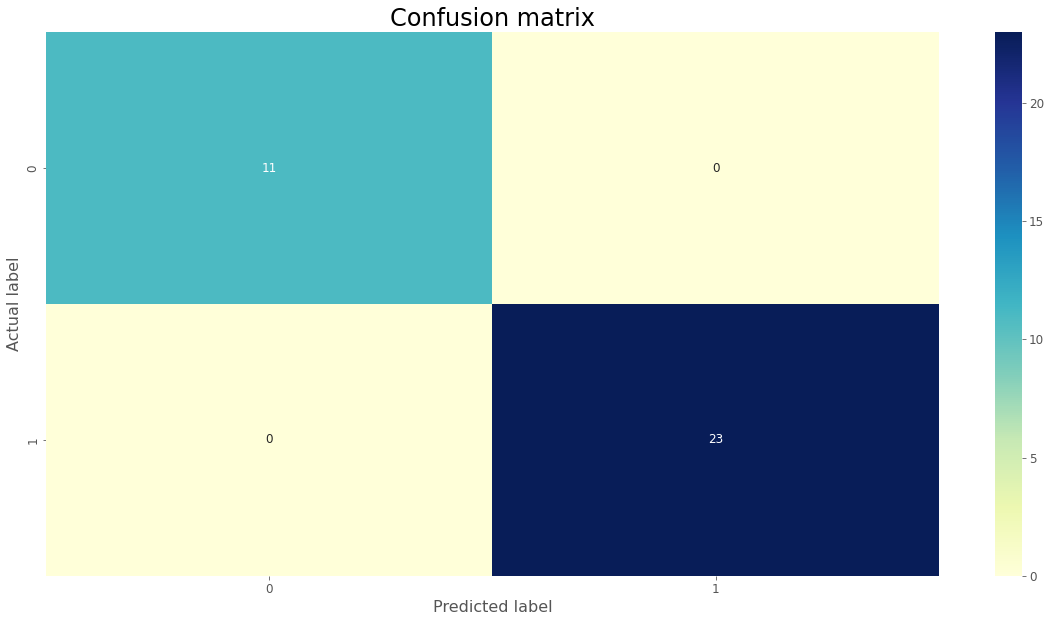

In [56]:
#Représentation graphique de la Matrice de confusion
sns.heatmap(pd.DataFrame(confusion_matrix), annot=True, cmap="YlGnBu" ,fmt='g')

plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

plt.savefig("confusion_matrix.png")
plt.show()

In [60]:
#Autres métriques d'évaluation du modèle 
print('  - Accuracy:' +str(round(metrics.accuracy_score(y_test, y_pred)*100, 2)), '%')
print('  - Precision:' +str(round(metrics.precision_score(y_test, y_pred)*100, 2)), '%')
print('  - Recall:' +str(round(metrics.recall_score(y_test, y_pred)*100, 2)), '%')
print('  - F1 score:' +str(round(metrics.f1_score(y_test, y_pred)*100, 2)), '%')

  - Accuracy:100.0 %
  - Precision:100.0 %
  - Recall:100.0 %
  - F1 score:100.0 %


L'évaluation de notre modèle nous a permis d'obternir un taux de classification de 100 %, considéré comme une bonne précision. 


La justesse ou accuracy ici de 100% nous informe sur le pourcentage de reponse correcte dans la globalité ( les vrais positifs comme les vrais négatifs). Il s'agit en fait de la somme du nbre  des vrais positifs et vrais négatifs sur le nbre total d'observations 

Précision: c'est-à-dire à quel point votre modèle est précis. En d'autres termes ou, lorsqu'un modèle fait une prédiction, à quelle fréquence elle est correcte. Dans notre cas de prédiction le  modèle de régression logistique affiche 100% de précision.  la précision s'interroge sur la précision du modele.
En effet a chaq fois que le modele predit que le billet est vrai il le predit a 100% .

REcall: Metrique qui montre la capacité du modele a identifié tous les vrais positifs . S'il y a des vrais billets  dans l'ensemble de tests notre modèle de régression logistique peut l'identifier 100% du temps.


Enfin, nous avons le score F1, qui prend en compte à la fois la précision et le rappel pour finalement mesurer la précision du modèle.

**Application sur le fichier test_exemple.csv**

Le modèle 'lr' étant validé, des prédictions peuvent-être menées sur d'autres jeux de données, essayons avec le second fichier que nous avons à disposition.

In [61]:
df0 = pd.read_csv('/gdrive/MyDrive/example.csv')
df0

diagonal  height_left  height_right  margin_low  margin_up  length   id
0    171.76       104.01        103.54        5.21       3.30  111.42  A_1
1    171.87       104.17        104.13        6.00       3.31  112.09  A_2
2    172.00       104.58        104.29        4.99       3.39  111.57  A_3
3    172.49       104.55        104.34        4.44       3.03  113.20  A_4
4    171.65       103.63        103.56        3.77       3.16  113.33  A_5

In [62]:
#Préparation des données
X = df0.copy()
X = X.iloc[:, :-1]

In [63]:
#Utilisation du modèle de prédiction 'lr'
probability = lr.predict_proba(X.values)[:, 1]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


In [64]:
#Probabilités des billets établies 
proba = pd.Series(probability.round(3), name='value')

In [65]:
#Intégration des probabilités dans le jeu de données
df0_final = pd.concat([df0, proba], axis=1)
df0_final

diagonal  height_left  height_right  ...  length   id  value
0    171.76       104.01        103.54  ...  111.42  A_1  0.044
1    171.87       104.17        104.13  ...  112.09  A_2  0.018
2    172.00       104.58        104.29  ...  111.57  A_3  0.030
3    172.49       104.55        104.34  ...  113.20  A_4  0.867
4    171.65       103.63        103.56  ...  113.33  A_5  0.996

[5 rows x 8 columns]

**Dataframe final avec résultats des classifications:**

Pour chaque billet, l'algorithme de classification donnera la probabilité que le billet soit vrai. Si cette probabilité est supérieure ou égale à 0.5, le billet sera considéré comme vrai. Dans le cas contraire, il sera considéré comme faux.

In [66]:
#Résultats de la classification prédictive :
resultat = []
for i in df0_final['value'] >= .5:
    if i is True :
        resultat.append('Vrai Billet')
    else :
        resultat.append('Faux Billet')

df0_final['resultat'] = resultat
df0_final

diagonal  height_left  height_right  ...   id  value     resultat
0    171.76       104.01        103.54  ...  A_1  0.044  Faux Billet
1    171.87       104.17        104.13  ...  A_2  0.018  Faux Billet
2    172.00       104.58        104.29  ...  A_3  0.030  Faux Billet
3    172.49       104.55        104.34  ...  A_4  0.867  Vrai Billet
4    171.65       103.63        103.56  ...  A_5  0.996  Vrai Billet

[5 rows x 9 columns]

Algorithme de classification des billets de banque à utiliser dans le cadre du test lors de la soutenance

In [1]:
#Import des librairies Python
import pandas as pd
from sklearn import preprocessing
import pickle

In [3]:
#Jeu de données qui sera fourni
df1 = '/gdrive/MyDrive/....csv'

In [ ]:
#Aperçu rapide du jeu de données
pd.read_csv(df1)

In [ ]:
#Fonction "detecteur_billet()" à utiliser dans l'étape suivante
def detecteur_billet(df1):
    """ Programme de détection de faux billets à partir d'un fichier .csv
        ici 'df1' 
    """
    
    # Chargement et préparation des données 
    df = pd.read_csv(df1)
    X = df.copy()
    X = X.iloc[:, :-1]
    
    # Centrage/réduction des données (éviter les écarts d'échelle, les données prendront toutes la même importance)
    std_scale = preprocessing.StandardScaler().fit(X)
    X_scaled = std_scale.transform(X)
    
    # Récupération du modèle de Régression Logistique 'lr'
    with open('model.pkl', 'rb') as f:
        my_unpickler = pickle.Unpickler(f)
        lr = my_unpickler.load()
    
    # Utilisation du modèle de prédiction 'lr'
    probability = lr.predict_proba(X_scaled)[:, 1]
    
    # Probabilités des billets établies 
    proba = pd.Series(probability.round(3), name='%value')
    
    # Intégration des probabilités dans le jeu de données
    df_final = pd.concat([df, proba], axis=1)
    
    # Résultats de la classification prédictive, selon une probabilité  supérieure ou égale à 0.5 :
    resultat = []
    for i in df_final['%value'] >= .5:
        if i is True :
            resultat.append('Vrai Billet')
        else :
            resultat.append('Faux Billet')

    df_final['resultat'] = resultat

    return df_final
    
    

In [ ]:
#Lancement de l'algorithme

#Pour chaque billet, l'algorithme de classification donnera la probabilité que le billet soit vrai. Si cette probabilité est supérieure ou égale à 0.5, le billet sera considéré comme vrai. Dans le cas contraire, il sera considéré comme faux.



In [ ]:
#Dernière étape avant l'affichage des prédictions 
detecteur_billet(df1)